# HW 7

In [1]:
#mydir = '/home/jkinser/Documents/courses/CDSCardinal/Version5/'
#mydir = '/Users/jkinser/Documents/CoursesKinser/CDSCardinal/Version5/'

mydir = '/Users/eric/Documents/CDS465/'

pysrc = mydir + 'pysrc/'
datadir = mydir + 'data/'
popdir = mydir + 'population/'

import sys
sys.path.append( pysrc )

import pandas as pd
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [2]:
import Main, island
E = Main.Realm( datadir )

E.ReadAll(popdir + 'pop3_6.db')
#E.ReadAll( popdir + 'mpop10.db')
len(E.persondf)

82525

# Task 1 - Moving out a Bad Neighborhoods
In class, we based the 'unhappiness' of citizens on their income. Your task is to change the algorithm such that unhappinness is based on _violentcrime_. Write a new function (based on _schellingmoves.py_) so that it considers _violentcrime_ instead of income. Evolve for 12 months. Show your island map (similar to MakeWealthMap).

I need to be able to run your codes. If you choose to put your functions inside of _schellingmoves.py_, then you will need to submit your modified module with your homework.

### CRIME FUNCTIONS:

In [3]:
import schellingmove as scm

def MakeCrimeDF( E ):
    s1 = E.persondf['hoh']==1 # HOH only
    keep = ['pid','violentcrime','income','locv','loch', 'dometh'] # ADD VC
    crimedf = E.persondf.loc[ s1 ][keep].copy()
    return crimedf

def MakeCrimeMap( crimedf ):	
	# create colummns with integer values for location
	crimedf['ilocv'] = crimedf['locv'].astype('int')
	crimedf['iloch'] = crimedf['loch'].astype('int')
	gcrime = crimedf.groupby( ['ilocv','iloch']).mean()
	crime2 = gcrime.reset_index()
	crime2 = crime2[['ilocv','iloch','violentcrime']]
	# put these values into an array
	x = crime2['iloch'].values
	y = crime2['ilocv'].values
	crime = crime2['violentcrime'].values
	crimemap = np.zeros( (2048,2048))
	crimemap[y,x] = crime
	answ = ndi.gaussian_filter( crimemap, 12 )
	return answ

def MakeNormalizedCrimeMap( crimedf ):
    a = MakeCrimeMap( crimedf )
    m = a.min()
    x = a.max()
    a = (a-m)/(x-m)
    return a

def DefineHappiness(crimedf, crimemap, gamma=0.7 ):
    vv = crimedf['ilocv'].values
    hh = crimedf['iloch'].values
    crimedf['VC'] = crimemap[vv,hh]
    unhappy = crimedf.loc[ crimedf['VC']>gamma].copy()
    return unhappy

def SchellingMover( E, gamma=0.7, show_IMG=False):
    crimedf_ = MakeCrimeDF( E )
    crimemap_ = MakeNormalizedCrimeMap( crimedf_ )
    if show_IMG: plt.imshow(crimemap_,cmap="gray")
    unhappy = DefineHappiness(crimedf_, crimemap_, gamma )
    scm.NewLocations( E, unhappy )
    scm.MoveFamilies( E, unhappy )

### INITIAL: STATE IMG

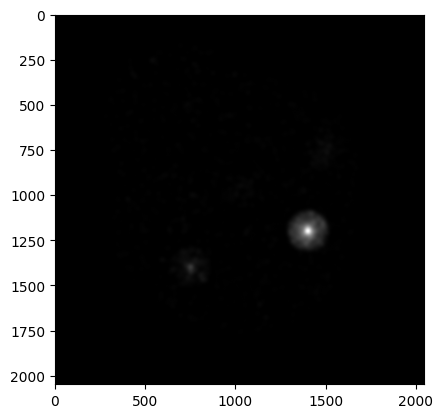

In [4]:
# your code and image

#Initial state at E.month == 0 
crimedf_ = MakeCrimeDF(E)
crimemap_ = MakeNormalizedCrimeMap(crimedf_)
plt.imshow(crimemap_, cmap='gray')

### DEFINE MyEvolve

In [5]:
#define MyEvolve

import population, nomad

def MyEvolve(E, Nmonths, addpeep, dometh, migrate=False, gamma=0.7):
    for i in range( Nmonths ):
        E.month += 1
        population.OneMonth( E, dometh, migrate=migrate)
        if addpeep>0:
            nomad.Immigrate( E, addpeep, dometh )
        # my stuff
        SchellingMover( E, gamma, True if i == Nmonths - 1 else False) #show image at end

### Run Code

8200
8212


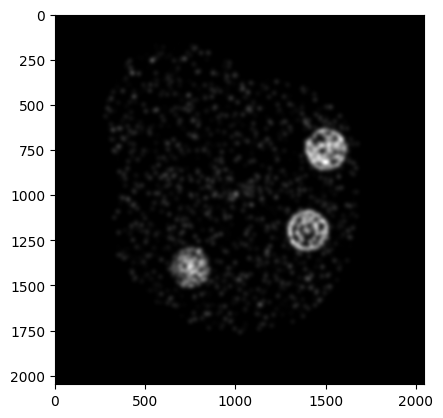

In [6]:
print(E.month)
MyEvolve(E,12,0,0,True)
print(E.month)

# Task 2 - Arrest the Gang
Use the data population generated from Task 1. 
1. Find the worst pixel on your island - the one with the highest average violent crime.
1. In a 9x9 area (The Block) surrounding this pixel, find all citizens with a violentcrime rating over 0.25, send them through WeDied to remove them from consideration. Evolve your population 12 months. 

Did The Block remain (mostly) free of violent crime? You can prove your point either through images or numerical analysis.

In [7]:
#Note: bad area (-4,+5)

#identify the bad block
crimemap_ = MakeNormalizedCrimeMap(MakeCrimeDF(E))
worst_area = np.argwhere(crimemap_ == crimemap_.max()) #v,h of most violent indices 
v_worst, h_worst = worst_area[0] #first most violent area

#calculate the bad block
OFFSET = 4 
v_min = np.clip(v_worst - OFFSET, 0, crimemap_.shape[0])
v_max = np.clip(v_worst + OFFSET + 1, 0, crimemap_.shape[0]) # Add +1 for slicing
h_min = np.clip(h_worst - OFFSET, 0, crimemap_.shape[1])
h_max = np.clip(h_worst + OFFSET + 1, 0, crimemap_.shape[1])
#bad_block_coords = np.array([v_min, v_max, h_min, h_max])

#get the before average (violentcrime) crime value for the block 
s1 = E.persondf['locv'].between(v_min,v_max)
s2 = E.persondf['loch'].between(h_min,h_max)
s3 =  E.persondf['death'] < 0 #get living people

b4_vc = E.persondf.loc[s1&s2&s3]['violentcrime']

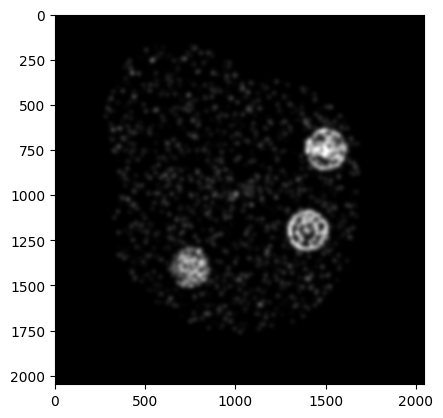

In [8]:
#bad_block_coords = np.array([v_min, v_max, h_min, h_max])

s1 = E.persondf['locv'].between(v_min, v_max) #person is within bounds
s2 = E.persondf['loch'].between(h_min, h_max)
s3 = E.persondf['violentcrime'] > 0.25 #person is violent
s4 = E.persondf['death'] < 0 #person is alive

diedDF = E.persondf.loc[s1 & s2 & s3 & s4]

import death

#pass in E and diedDF
death.WeDied(E, diedDF)

crimemap_p2_b4 = MakeNormalizedCrimeMap(MakeCrimeDF(E))
plt.imshow(crimemap_p2_b4, cmap='gray')

8212
8224


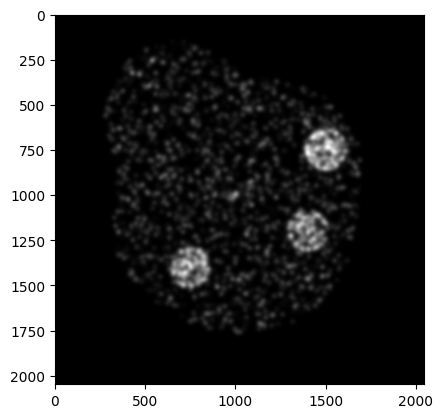

In [9]:
print(E.month)
MyEvolve(E,12,0,0,True)
print(E.month)

In [10]:
#get the after average (violentcrime) crime value for the block 
s1 = E.persondf['locv'].between(v_min,v_max)
s2 = E.persondf['loch'].between(h_min,h_max)
s3 =  E.persondf['death'] < 0 #get living people

after_vc = E.persondf.loc[s1&s2&s3]['violentcrime']

In [11]:
#calcs
print('Before mean: ', b4_vc.mean(), 'After mean: ', after_vc.mean())

print('Diff in means: ', b4_vc.mean()-after_vc.mean())

print('Before total: ', b4_vc.sum(), 'After total: ', after_vc.sum())

print('Difference in totals: ', b4_vc.sum()-after_vc.sum())

Before mean:  0.4548333245402572 After mean:  0.17480215264716475
Diff in means:  0.28003117189309246
Before total:  7.732166517184373 After total:  3.4960430529432953
Difference in totals:  4.236123464241078


It seems, following the untimely retirement from life of the "bad block", the crime in the area where the "bad block" was has not been able to propogate back into that area.

# Task 3
Do citizens exist that are not of e0 but have blue eyes, who also have a bio maternal ancestor who was did not carry the blue eye gene?
People with recessive1=2 have blue eyes. Those with a value of 1 are carriers. Those with values of 0 do not carry the gene.

1. Find a living, person who is e1,e2,or e3 and they have blue eyes (recessive1 = 2)
1. Get this person's bio maternal lineage, until you reach a bio-mom ancestor with recessive1 = 0
1. Print out all citizens in this maternal lineage.['pid','firstname','lastname','biomom','recessive1']
1. If you get a person who's lineage goes back to an immigrant or whose lineage is 3 or less, then pick another citizen to test.


#### 1. Find a living, person who is e1,e2,or e3 and they have blue eyes (recessive1 = 2)


In [12]:
set(E.persondf['dometh'])

{0, 1, 2, 3}

In [13]:
# your code
s1 = E.persondf['dometh'] != 1 #get any person who is dometh e1, e2, or e3
s2 = E.persondf['death'] < 0 #get living people
s3 = E.persondf['recessive1'] == 2 #get people who have blue eyes; recessive1 == 2

r1_2_pool = E.persondf.loc[s1&s2&s3]

sample_person = r1_2_pool.sample(1,random_state = 0)

cols = ['pid','firstname','lastname','biomom','recessive1']
sample_person[cols]

,pid,firstname,lastname,biomom,recessive1
67428,67429,Omni,qiao,61217,2


#### 2. Get this person's bio maternal lineage, until you reach a bio-mom ancestor with recessive1 = 0

In [14]:
mat_lineage0 = E.persondf.loc[sample_person.index][['pid', 'biomom']].values.flatten() #get maternal lineage pids
lineage_0 = E.persondf.loc[E.persondf['pid'].isin(mat_lineage0)][cols] #get people who are of the lineage

mat_lineage1 = E.persondf.loc[lineage_0.index][['pid', 'biomom']].values.flatten()
lineage_1 = E.persondf.loc[E.persondf['pid'].isin(mat_lineage1)][cols]

mat_lineage2 = E.persondf.loc[lineage_1.index][['pid', 'biomom']].values.flatten()
lineage_2 = E.persondf.loc[E.persondf['pid'].isin(mat_lineage2)][cols]

mat_lineage3 = E.persondf.loc[lineage_2.index][['pid', 'biomom']].values.flatten()
lineage_3 = E.persondf.loc[E.persondf['pid'].isin(mat_lineage3)][cols]

lineage_3

,pid,firstname,lastname,biomom,recessive1
46269,46270,Deani,jing,42051,0
50870,50871,Alianni,kou,46270,0
55424,55425,Analee,chan,50871,1
61216,61217,Canela,gongliang,55425,1
67428,67429,Omni,qiao,61217,2


#### 3. Print out all citizens in this maternal lineage.['pid','firstname','lastname','biomom','recessive1']

In [15]:
lineage_3

,pid,firstname,lastname,biomom,recessive1
46269,46270,Deani,jing,42051,0
50870,50871,Alianni,kou,46270,0
55424,55425,Analee,chan,50871,1
61216,61217,Canela,gongliang,55425,1
67428,67429,Omni,qiao,61217,2


#### 4. If you get a person who's lineage goes back to an immigrant or whose lineage is 3 or less, then pick another citizen to test.